# Natural language inference with transformers

### Libraries and Variables

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib
from matplotlib.colors import Normalize
from IPython.display import display, HTML
import spacy
import os
from captum.attr import IntegratedGradients
import pickle
import json
import ssl
import random
import matplotlib.pyplot as plt
ssl._create_default_https_context = ssl._create_unverified_context

home_dir = os.path.expanduser('~')
############################ delete
home_dir = '/usr/users/henrich1'
############################
raw_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/raw_data')
output_data_dir = os.path.join(home_dir, 'repos/DaNuMa2024/data/output_data')

### Overview

In this exercise, you will tackle a task called 'natural language inference'. In this task, there are two sentences and it should be classified which relation *sentence 1* has to *sentence 2*. The three classes are **contradiction**, **neutral** and **entailment**. Let's look at an example for each class:

**Contradiction**
- *Sentence 1*: The sky is clear and blue.
- *Sentence 2*: It is raining heavily.
- *Explanation*: These two sentences directly contradict each other. If the sky is clear and blue, it cannot be raining heavily at the same time.

**Neutral**
- *Sentence 1*: A woman is walking in the park.
- *Sentence 2*: She is listening to music.
- *Explanation*: These two sentences are neutral because knowing that a woman is walking in the park does not tell us whether she is listening to music. Both can be true, but one doesn’t necessarily imply or contradict the other.

**Entailment**
- *Sentence 1*: The child is playing with a soccer ball.
- *Sentence 2*: A child is playing.
- *Explanation*: If the first sentence is true, it logically entails that the second sentence must also be true. If a child is playing with a soccer ball, it’s clear that the child is playing.

you will build, train and evaluate a transformer model for this basic natural language classification task. Pytorch already has the basic building blocks of transformers implemented. So you do not need to implement the attention mechanism from scratch.


### Data Loading and Preprocessing

We will start by loading the data. Originally, it is stored as dictionaries in the json format. However, we want to have a more human-readable format so that we extract the relevant information and store it in a pandas dataframe. This is already implemented and performed in the code cell below:

In [2]:
# Function to convert label to numeric form
def label_to_numeric(label):
    assert label in ['contradiction', 'neutral', 'entailment']
    if label == 'contradiction':
        return 0
    elif label == 'neutral':
        return 1
    elif label == 'entailment':
        return 2

def get_df_from_jsonl(path):
    with open(path) as f:
        data = [json.loads(line) for line in f]
        
    data_rows = []
    for item in tqdm(data):
        gold_label = item['gold_label']
        sentence1 = item['sentence1']
        sentence2 = item['sentence2']
        concatenated_sentences = f"{sentence1} <sep> {sentence2}"
        
        # for some sentence pairs, a gold label does not exist. We will not include these in the dataset
        if not gold_label in ['contradiction', 'neutral', 'entailment']:
            continue
        label_numeric = label_to_numeric(gold_label)
        
        data_rows.append({
            'label_text': gold_label,
            'label_numeric': label_numeric,
            'sentence1': sentence1,
            'sentence2': sentence2,
            'concatenated': concatenated_sentences
        })
    return pd.DataFrame(data_rows)
    
    
train_path = os.path.join(raw_data_dir, '8_natural_language_inference/snli_1.0_train.jsonl')
val_path = os.path.join(raw_data_dir, '8_natural_language_inference/snli_1.0_dev.jsonl')
test_path = os.path.join(raw_data_dir, '8_natural_language_inference/snli_1.0_test.jsonl')

train_df = get_df_from_jsonl(train_path)
val_df = get_df_from_jsonl(val_path)
test_df = get_df_from_jsonl(test_path)

# look at the first few rows
train_df.head()

100%|██████████| 10000/10000 [00:00<00:00, 458684.63it/s]


,label_text,label_numeric,sentence1,sentence2,concatenated
0,neutral,1,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,A person on a horse jumps over a broken down a...
1,contradiction,0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",A person on a horse jumps over a broken down a...
2,entailment,2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",A person on a horse jumps over a broken down a...
3,neutral,1,Children smiling and waving at camera,They are smiling at their parents,Children smiling and waving at camera <sep> Th...
4,entailment,2,Children smiling and waving at camera,There are children present,Children smiling and waving at camera <sep> Th...


We also created a new column in the dataframe ('concatenated') that combines both sentences and separates them with a separator token ('\<sep\>'):

In [3]:
print(f"Example of concatenated sentences: {train_df.loc[0, 'concatenated']}")

Example of concatenated sentences: A person on a horse jumps over a broken down airplane. <sep> A person is training his horse for a competition.


These concatenated sentences will be used as input to our model. This way, the model has access to both sentences and can reason about the relation between them. However, the model cannot take raw strings as input. Therefore, we first have to convert these strings into numbers. A common approach to convert natural language into a sequence of numbers consists of the following two steps:
1. **Tokenize the sentence**. Tokenization describes the process of breaking up natural language into individual building blocks (called 'tokens'). In many cases, these tokens are just words, but there are also exceptions. For example, some tokenizers break up verbs in *gerund* like 'going' into two tokens 'go' and 'ing'. Punctuation marks are also separate tokens. The result of tokenizing a sentence is simply a list of tokens that form the sentence. There are various python libraries that offer readily usable tokenizers.
2. **Build vocabulary from tokens to map them onto integer numbers**: Once we have tokens for all of our data, we can use it to build a vocabulary, i.e. the set of all unique tokens in our data. We can then identify each token by a number and use this correspondence to map tokens to numbers. For example, the first entry in our vocabulary might be 'the'. Then, the 'the' token will be mapped onto the number '1'. This way, we will obtain sequences of numbers that represent our natural language input.

Since models usually take equally sized examples as input for batching (remember last exercises where this has always been the cases), we will have to ensure that all number sequences have the same length. This is done by selecting a long-enough sequence length (e.g. by looking at the longest input) and then padding sequences that are shorter with zeros until they all have the same length. The process of building the vocabulary and mapping tokens onto numbers takes relatively long. This is why you should not run the two code cells below. The result of running it is already provided and can be directly loaded.

In [4]:
# # look at longest sentence
# max_len = train_df['concatenated'].apply(lambda x: len(x.split())).max()
# print(max_len) 
# # longest concanaated sentence has 113 words
# # --> 150 tokens should be enough to cover (almost) all cases

In [5]:
# nlp = spacy.load('en_core_web_sm')  # Load a small English language model for tokenization

# # Tokenization and Vocabulary Building
# def tokenize(text):
#     return [token.text.lower() for token in nlp(text)]

# # Build vocabulary from training data
# def build_vocab(texts, start_index=1):
#     vocab = {}
#     index = start_index
#     for text in tqdm(texts):
#         tokens = tokenize(text)
#         for token in tokens:
#             if token not in vocab:
#                 vocab[token] = index
#                 index += 1
#     return vocab

# # Build vocabulary
# vocab = build_vocab(train_df['concatenated'])
# print(f'Vocabulary size: {len(vocab)}')

# # Convert tokens to indices and pad sequences
# def text_to_sequence(text, vocab, n_tokens):
#     tokens = tokenize(text)
#     sequence = [vocab.get(token, 0) for token in tokens]  # Convert to indices; use 0 for OOV tokens
#     if len(sequence) < n_tokens:
#         sequence = sequence + [0] * (n_tokens - len(sequence)) # Pad sequences
#     else:
#         sequence = sequence[:n_tokens]  # Truncate sequences
#     return sequence

# # Apply to datasets
# n_tokens = 150
# train_df['concatenated_num'] = train_df['concatenated'].apply(lambda x: text_to_sequence(x, vocab, n_tokens))
# val_df['concatenated_num'] = val_df['concatenated'].apply(lambda x: text_to_sequence(x, vocab, n_tokens))
# test_df['concatenated_num'] = test_df['concatenated'].apply(lambda x: text_to_sequence(x, vocab, n_tokens))

# # save vocab and data
# save_dir = os.path.join(raw_data_dir, '8_natural_language_inference')
# os.makedirs(save_dir, exist_ok=True)
# save_path_vocab = os.path.join(save_dir, 'vocab.pkl')
# save_path_train = os.path.join(save_dir, 'df_train.pkl')
# save_path_val = os.path.join(save_dir, 'df_val.pkl')
# save_path_test = os.path.join(save_dir, 'df_test.pkl')

# with open(save_path_vocab, "wb") as file:
#     pickle.dump(vocab, file)
# train_df.to_pickle(save_path_train)
# val_df.to_pickle(save_path_val)
# test_df.to_pickle(save_path_test)

To directly load the dataframes with the mapped tokens, run the code cell below:

In [2]:
# Load the dictionary and dataframes from the file
save_dir = os.path.join(raw_data_dir, '8_natural_language_inference')
save_path_vocab = os.path.join(save_dir, 'vocab.pkl')
save_path_train = os.path.join(save_dir, 'df_train.pkl')
save_path_val = os.path.join(save_dir, 'df_val.pkl')
save_path_test = os.path.join(save_dir, 'df_test.pkl')

with open(save_path_vocab, "rb") as file:
    vocab = pickle.load(file)
train_df = pd.read_pickle(save_path_train).reset_index(drop=True)
val_df = pd.read_pickle(save_path_val).reset_index(drop=True)
test_df = pd.read_pickle(save_path_test).reset_index(drop=True)

# look at first few rows
train_df.head()

,label_text,label_numeric,sentence1,sentence2,concatenated,concatenated_num
0,neutral,1,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,A person on a horse jumps over a broken down a...,"[1, 2, 3, 1, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, ..."
1,contradiction,0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",A person on a horse jumps over a broken down a...,"[1, 2, 3, 1, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, ..."
2,entailment,2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",A person on a horse jumps over a broken down a...,"[1, 2, 3, 1, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, ..."
3,neutral,1,Children smiling and waving at camera,They are smiling at their parents,Children smiling and waving at camera <sep> Th...,"[26, 27, 28, 29, 19, 30, 11, 12, 13, 31, 32, 2..."
4,entailment,2,Children smiling and waving at camera,There are children present,Children smiling and waving at camera <sep> Th...,"[26, 27, 28, 29, 19, 30, 11, 12, 13, 35, 32, 2..."


Get an overview about the dataset:
* Are the number of labels for the different classes roughly equal for the training, validation and test set?
* Take a look at the first row of the training dataset. Do the numerical sequences generated by the mapping make sense when comparing them to the actual sentences?

In [7]:
######### YOUR CODE HERE:
# explore category distribution
print(train_df['label_text'].value_counts())
print('\n')
print(val_df['label_text'].value_counts())
print('\n')
print(test_df['label_text'].value_counts())

# distribution is roughly equal in all datasets

label_text
entailment       183416
contradiction    183187
neutral          182764
Name: count, dtype: int64


label_text
entailment       3329
contradiction    3278
neutral          3235
Name: count, dtype: int64


label_text
entailment       3368
contradiction    3237
neutral          3219
Name: count, dtype: int64


In [8]:
######### YOUR CODE HERE:
# qualitatively look at first row of training dataset and compare numerical sequence with text
print(f"sentence 1: {train_df.loc[0, 'sentence1']}")
print(f"sentence 2: {train_df.loc[0, 'sentence2']}")
print(f"concatenated sentences: {train_df.loc[0, 'concatenated']}")
print(f"concatenated sentences (numerical): {train_df.loc[0, 'concatenated_num']}")
print(f"label: {train_df.loc[0, 'label_text']}")

# The mapping seems to have been generated starting from the first row of the training dataframe since the numerical sequence starts with '1, 2, 3'. 
# Once a word repeats (e.g. the fourth word is again 'a'), the numerical sequence repeats the same number as before (in this case '1').
# So everything seems to have worked as expected.

sentence 1: A person on a horse jumps over a broken down airplane.
sentence 2: A person is training his horse for a competition.
concatenated sentences: A person on a horse jumps over a broken down airplane. <sep> A person is training his horse for a competition.
concatenated sentences (numerical): [1, 2, 3, 1, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13, 1, 2, 14, 15, 16, 4, 17, 1, 18, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
label: neutral


### Dataset and DataLoader

Next, let's create a PyTorch `Dataset`:
* It should take the dataframe as input in the constructor and save it as an attribute. 
* The ``getitem`` method should index the dataframe and return a tuple consisting of (1) the numerical sequence (``concatenated_num``) and (2) the numerical label (``label_numeric``). Both should be returned as ``torch.long``. 
* Check if they return the correct data.

In [3]:
class NLIDataset(Dataset):
    ######### YOUR CODE HERE:
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        sequence = torch.tensor(self.dataframe.iloc[idx]['concatenated_num'], dtype=torch.long)
        label = torch.tensor(self.dataframe.iloc[idx]['label_numeric'], dtype=torch.long)
        return sequence, label

# Create datasets
train_dataset = NLIDataset(train_df)
val_dataset = NLIDataset(val_df)
test_dataset = NLIDataset(test_df)

# create dataloaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test the dataset
train_dataset[0]

(tensor([ 1,  2,  3,  1,  4,  5,  6,  1,  7,  8,  9, 10, 11, 12, 13,  1,  2, 14,
         15, 16,  4, 17,  1, 18, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0]),
 tensor(1))

### Building the Transformer Model

Now, let's define the Transformer model for natural language inference. If you want to first understand the transformer in more detail, there is this great tutorial online: https://jalammar.github.io/illustrated-transformer\
Since Pytorch provides readily usable transformer modules, you will not need to implement the attention mechanism yourself. Still, many of the building blocks that are required are new for you. So make sure to read the documentation to find out how to use them. The model consists of the following building blocks:

1. **Embedding Layer**: The input sequences are just integers. In the transformer model, each token is represented by a high-dimensional vector since it has a stronger representational capacity. Use the module ``nn.Embedding`` to map the integer tokens onto a vectors of the dimension **embed_dim**. When instantiating the module, the size of the vocabulary (**vocab_size**) is also required. That is because the module must learn for every index in the vocabulary, a corresponding high-dimensional vector.
2. **Positional Encoding**: When you look at the attention formulas (see e.g. linked tutorial), you will notice that the position of the tokens is not used in the calculation of the attention. The transformer is in principle agonistic to the ordering of tokens! That means we have to explicitly encode the position of tokens before we pass them to the transformer if we want the model to use this information. The easiest way to do this is to use a learned positional encoding (use ``nn.Parameter``) and simply add it to the embeddings elementwise. We know that we always have **n_tokens** tokens since we pad with zeros. That means the learned positional encoding should have the size **n_tokens x embed_dim**. We can add this positional encoding to the embeddings which also have the size **n_tokens x embed_dim**.
3. **Transformer Encoder**: To define the individual layers in the transformer encoder, use ``nn.TransformerEncoderLayer``. Provide the arguments **embed_dim**, **num_heads**, **dim_feedforward** and set batch_first=True. The individual layers can be combined using ``nn.TransformerEncoder``. This module takes as arguments the previously defined ``nn.TransformerEncoderLayer`` and the number of layers (**num_layers**)
4. **Final Classification Layer**: After the tokens have aggregated information through the transformer encoder, the output will still have size **n_tokens x embed_dim**. For the final classification, take the average across tokens and map the resulting vector of dimension **embed_dim** to three classes using a linear layer.

In [4]:
# we use learned positional encoding here, but using fixed positional encoding leads to similar results
class TransformerNLIModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, dim_feedforward, n_tokens):
        super().__init__()
        ######### YOUR CODE HERE:
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, n_tokens, embed_dim))
        encoder_layers = nn.TransformerEncoderLayer(embed_dim, num_heads, dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(embed_dim, 3)
        
    def forward(self, x, embedded=False, use_pos_encoder=True):
        # If x is already an embedding, we don't pass it through the embedding layer (this was not specified in the task, but will be needed later)
        if not embedded:
            x = self.embedding(x) * np.sqrt(x.size(-1))
        
        # If use_pos_encoder is False, we don't use positional encoding (this was not specified in the task, but could be useful for comparison studies)
        if use_pos_encoder:
            x = x + self.pos_encoding
        
        output = self.transformer_encoder(x)
        output = output.mean(dim=1)
        output = self.fc(output)
        return output
    
# # this fixed positional encoding could be used instead of the learned positional encoding
# class PositionalEncodingFixed(nn.Module):
#     def __init__(self, embed_dim, n_tokens):
#         super().__init__()
#         pe = torch.zeros(n_tokens, embed_dim)
#         position = torch.arange(0, n_tokens, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)  # (1, n_tokens, embed_dim)
#         self.register_buffer('pe', pe)
    
#     def forward(self, x):
#         x = x + self.pe
#         return x

### Training the Model

Once again, the training and evaluation functions are very similar to the previous exercises, so they are just provided:

In [5]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for sequences, labels in tqdm(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        all_preds.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds).argmax(1)
    train_accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(train_loader), train_accuracy

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for sequences, labels in tqdm(val_loader):
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds).argmax(1)
    val_accuracy = accuracy_score(all_labels, all_preds)
    return total_loss / len(val_loader), val_accuracy, all_labels, all_preds

Due to time limitations, we will just train the model for 5 epochs (~20 mins). Performance will be much better when training longer! But you should still achieve roughly 65\% accuracy within 5 epochs.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# model
vocab_size = len(vocab) + 1  # Teh vocabulary does not include the padding index (0)! So we need to add 1 to the vocab size
embed_dim = 100
num_heads = 10
num_layers = 3
dim_feedforward = 512
batch_first = True
n_tokens = 150

model = TransformerNLIModel(vocab_size, embed_dim, num_heads, num_layers, dim_feedforward, batch_first, n_tokens)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# save best model state dict
save_dir_state_dict = os.path.join(output_data_dir, '8_natural_language_inference')
os.makedirs(save_dir_state_dict, exist_ok=True)
save_path_state_dict = os.path.join(save_dir_state_dict, 'best.pth')
save_path_metrics = os.path.join(save_dir_state_dict, 'metrics.pkl')

# training parameters
num_epochs = 5
lr = 0.001

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), save_path_state_dict)

    metrics = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    })
    metrics.to_pickle(save_path_metrics)
    
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')

### Results

Plot the results:

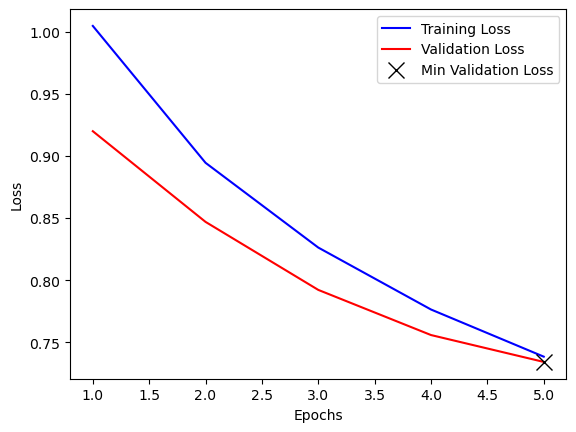

In [86]:
results = pd.read_pickle(save_path_metrics)

####################### plot losses
n = len(results)
plt.plot(np.linspace(1, n, n), results['train_loss'], c='blue', label='Training Loss')
plt.plot(np.linspace(1, n, n), results['val_loss'], c='red', label='Validation Loss')

# Mark the minimum validation loss
index = np.argmin(results['val_loss'])
plt.plot(index+1, results['val_loss'][index], 'kx', label='Min Validation Loss', markersize=12)

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

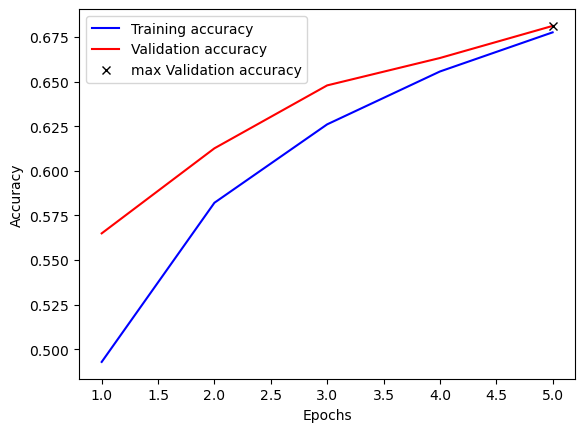

maximum validation accuracy: 0.6812


In [87]:
results = pd.read_pickle(save_path_metrics)

####################### plot accuracies
n = len(results)
plt.plot(np.linspace(1, n, n), results['train_accuracy'], c='blue', label='Training accuracy')
plt.plot(np.linspace(1, n, n), results['val_accuracy'], c='red', label='Validation accuracy')

# Mark the maximum validation accuracy
index = np.argmax(results['val_accuracy'])
plt.plot(index+1, results['val_accuracy'][index], 'kx', label='max Validation accuracy')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# print maximum accuracy
print(f'maximum validation accuracy: {np.max(val_accuracies):.4f}')

To obtain test results, we can also use the evaluate function:

In [20]:
####################### evaluate test performance
# Load the best model
vocab_size = len(vocab) + 1  # Teh vocabulary does not include the padding index (0)! So we need to add 1 to the vocab size
embed_dim = 100
num_heads = 10
num_layers = 3
dim_feedforward = 512
batch_first = True
n_tokens = 150

model = TransformerNLIModel(vocab_size, embed_dim, num_heads, num_layers, dim_feedforward, batch_first, n_tokens)
model = model.to(device)
model.load_state_dict(torch.load(save_path_state_dict))

# get test loss
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_accuracy:.4f}')


100%|██████████| 10/10 [00:02<00:00,  4.25it/s]


Test Accuracy: 0.8227


Using ``all_labels`` and ``all_preds``, plot a confusion matrix (see also exercise 4_convnet). Are all classes equally hard to predict?

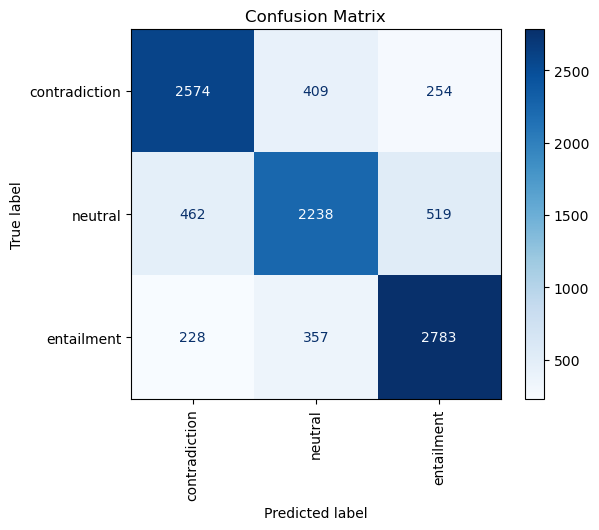

In [11]:
######### YOUR CODE HERE:
# Compute the confusion matrix
classes = ["contradiction", "neutral", "entailment"]
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# It is visible that the model does not easily confuse the classes "entailment" and "contradiction", probably because the difference between the sentences is often quite large.
# The "neutral" class has a higher error rate than the other classes. Apparently, the distinction to both other classes is less clear than the one between "entailment" and "contradiction".
# Further analyses would be necessary to determine why exactly this is the case.

### Explainability via integrated gradients

In this section, you will not have to write any code yourself. The goal is to simply introduce an explainability method for deep learning methods, namely the so-called "integrated gradients" method. Intuitively, this method computes the gradient of the output with respect to the model input to determine which features (in our case tokens) are the most important. These features will have the highest gradient. We can use this method to visualize token importance. The method can also be applied to images or other types of inputs and offers a nice way to add explainability to methods. To run the code below, you need to copy the ``TransformerNLIModel`` from the solution here since a small modification is needed for integrated gradients. We will also take a model checkpoint that was (1) trained for 30 epochs and (2) with pre-trained token embeddings (more on that in the next section). The results are much better (82\% test accuracy) such that attributions will be clearer.

In [29]:
# get reverse vocabulary where keys are indices and values are words
reverse_vocab = {value: key for key, value in vocab.items()}
assert len(vocab) == len(reverse_vocab)
reverse_vocab[0] = '<PAD>'

In [33]:
# use the IntegratedGradients class from the captum library to compute the attributions with respect to a "target". 
# In our case we have three outputs since we have three classes and we can compute the attributions with respect to either of the output channels. This can be specified by "target".
def get_attributions(input, target):
    # forward function to use for computing integrated gradients
    def forward_func(embeddings):
        return model(embeddings, embedded=True)

    # Create the IntegratedGradients instance
    ig = IntegratedGradients(forward_func)

    # manually perform first step of the model (embedding layer) since integrated gradients does not work with the original inputs since they are just indices
    embeddings = model.embedding(input) * np.sqrt(input.size(-1))

    # Compute attributions with respect to the embeddings for the target class (we will input the predicted class to visualize what caused the prediction)
    attributions = ig.attribute(inputs=embeddings, target=target)
    return attributions.detach().cpu().numpy()

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the best model
vocab_size = len(vocab) + 1  # Teh vocabulary does not include the padding index (0)! So we need to add 1 to the vocab size
embed_dim = 100
num_heads = 10
num_layers = 3
dim_feedforward = 512
batch_first = True
n_tokens = 150

model = TransformerNLIModel(vocab_size, embed_dim, num_heads, num_layers, dim_feedforward, batch_first, n_tokens)
model = model.to(device)
save_path_pretrained_state_dict = os.path.join(raw_data_dir, '8_natural_language_inference/best_pretrained.pth')
model.load_state_dict(torch.load(save_path_pretrained_state_dict))

# get prediction, labels, text and corresponding attributions for the first 100 samples in the test dataset
tokenized_texts = []
labels_numeric = []
labels_text = []
all_attributions = []
predictions = []
for _, row in tqdm(test_df.iterrows()):
    x = row['concatenated_num']
    x = torch.tensor(x, dtype=torch.long).unsqueeze(0).to(device)
    
    # tokenized text
    tokenized_text = [reverse_vocab[index.item()] for index in x[0]]
    tokenized_texts.append(tokenized_text)
    
    # labels
    label_numeric = row['label_numeric']
    labels_numeric.append(label_numeric)
    label_text = row['label_text']
    labels_text.append(label_text)
    
    # prediction
    model.eval()
    with torch.no_grad():
        output = model(x, embedded=False)
    prediction = output.argmax(1).item()
    predictions.append(prediction)
    
    # attributions
    attributions = get_attributions(x, prediction)
    all_attributions.append(attributions)
    
    if _ == 100:
        break

100it [00:02, 41.64it/s]


Let's look at some of the predictions. Note that we always computed the attributions for the *predicted class*. A high attribution value of a token means that it had a positive impact for making this prediction. For example, let's look at the 100th prediction:

In [55]:
ind = 100
print(f'text label: {labels_text[ind]}')
print(f'numeric label: {labels_numeric[ind]}')
print(f'numeric prediction: {predictions[ind]}')
print('\n')
print(test_df.iloc[ind]['sentence1'])
print(test_df.iloc[ind]['sentence2'])

text label: contradiction
numeric label: 0
numeric prediction: 0


A woman within an orchestra is playing a violin.
A man is looking in a telescope.


The prediction is correct. Let's see what had the highest influence in making this prediction. For this we color the average token attribution. *Dark red* means that these tokens had a negative influence on the prediction, while *dark green* means the influence was positive:

In [56]:
# mean attribution score across all dimensions of the embeddings to get overall importance of each token
mean_attributions = np.mean(all_attributions[ind].squeeze(), axis=1)  # Replace with your actual attributions

# Filter out padding tokens
filtered_tokens = [token for token in tokenized_texts[ind] if token != "<PAD>"]
filtered_attributions = mean_attributions[:len(filtered_tokens)]

# Normalize the attributions scores to values between 0 and 1 for coloring
norm = Normalize(vmin=min(filtered_attributions), vmax=max(filtered_attributions))
cmap = matplotlib.colormaps.get_cmap("RdYlGn")  # Red (negative) to green (positive)

# Create HTML for colored text visualization
colored_text = ""
for token, score in zip(filtered_tokens, filtered_attributions):
    color = cmap(norm(score))  # Get color from normalized score
    color_hex = matplotlib.colors.rgb2hex(color[:3])  # Convert RGB to hex
    colored_text += f'<span style="color: {color_hex}">{token}</span> '

# Display the colored text as HTML
display(HTML(f"<p style='font-size: 16px;'>{colored_text}</p>"))

We see that the word *woman* had a high positive influence on the *contradition* prediction. Apparently, the model focused on the contrast between *man* and *woman* in the two sentences to conclude that there is a contradiction. Obviously, these attributions are not that easily interpretable. Obviously the presence of *man* is just as important in determining the contradiction even though it is colored in red. Nevertheless, the attributions (also the magnitude) give a rough idea of what is important for the model, but admittedly it might not be the perfect method for the task at hand. Feel free to look at further examples and try to identify patterns :)

### Pretrained word vectors

When we trained our transformer, we trained the *embeddings* for each token from scratch. In practice this is rarely done since embeddings that have been obtained by training on huge language corpora are readily available. In this section, we will explore pretrained GloVe embeddings (Global Vectors for Word Representation) and investigate whether closeness between embeddings relates to semantic closeness. First, we will load the embeddings and create a vocabulary:

In [6]:
glove_file_path = os.path.join(raw_data_dir, '8_natural_language_inference/glove.6B.100d.txt')

# Open the GloVe file and read line by line. Obtain all words and embeddings
reverse_vocab = dict()
all_embeddings = []
with open(glove_file_path, "r", encoding="utf-8") as f:
    for i, line in tqdm(enumerate(f)):
        values = line.split()
        # get tokens
        word = values[0]
        reverse_vocab[i] = word
        # get embeddings
        embedding = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32).unsqueeze(0)
        all_embeddings.append(embedding)

# get all embeddings as tensor and create vocab with swapped keys and values
all_embeddings = torch.cat(all_embeddings, dim=0)
vocab = {value: key for key, value in reverse_vocab.items()}
assert len(vocab) == len(reverse_vocab)

400000it [00:16, 24731.71it/s]


Let's print the vocabulary and embeddings:

In [54]:
index = 0
print(f'example token: {reverse_vocab[index]}')
print(f'corresponding embedding: {all_embeddings[index]}')

example token: the
corresponding embedding: tensor([-0.0382, -0.2449,  0.7281, -0.3996,  0.0832,  0.0440, -0.3914,  0.3344,
        -0.5755,  0.0875,  0.2879, -0.0673,  0.3091, -0.2638, -0.1323, -0.2076,
         0.3340, -0.3385, -0.3174, -0.4834,  0.1464, -0.3730,  0.3458,  0.0520,
         0.4495, -0.4697,  0.0263, -0.5415, -0.1552, -0.1411, -0.0397,  0.2828,
         0.1439,  0.2346, -0.3102,  0.0862,  0.2040,  0.5262,  0.1716, -0.0824,
        -0.7179, -0.4153,  0.2033, -0.1276,  0.4137,  0.5519,  0.5791, -0.3348,
        -0.3656, -0.5486, -0.0629,  0.2658,  0.3020,  0.9977, -0.8048, -3.0243,
         0.0125, -0.3694,  2.2167,  0.7220, -0.2498,  0.9214,  0.0345,  0.4674,
         1.1079, -0.1936, -0.0746,  0.2335, -0.0521, -0.2204,  0.0572, -0.1581,
        -0.3080, -0.4162,  0.3797,  0.1501, -0.5321, -0.2055, -1.2526,  0.0716,
         0.7056,  0.4974, -0.4206,  0.2615, -1.5380, -0.3022, -0.0734, -0.2831,
         0.3710, -0.2522,  0.0162, -0.0171, -0.3898,  0.8742, -0.7257, -0.51

A common way to measure similarity between vectors is the cosine similarity. For two vectors \( A \) and \( B \), the cosine similarity is given as:

$$
\cos(\theta) = \frac{A \cdot B}{|A| |B|} = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \sqrt{\sum_{i=1}^{n} B_i^2}}
$$

The cosine similarity takes on values between -1 and 1. A value of 1 means that the vectors are identical and -1 that they are diametrically opposing.

#### Example:
Let’s consider two 2D vectors:

\( A = (1, 1) \)  
\( B = (1, 0.5) \)

First, calculate the dot product \( A $\cdot$ B \):

$$
A \cdot B = (1 \cdot 1) + (1 \cdot 0.5) = 1 + 0.5 = 1.5
$$

Now, calculate the magnitudes \( |A| \) and \( |B| \):

$$
|A| = \sqrt{(1^2 + 1^2)} = \sqrt{1 + 1} = \sqrt{2}
$$

$$
|B| = \sqrt{(1^2 + 0.5^2)} = \sqrt{1 + 0.25} = \sqrt{1.25}
$$

Now, plug these values into the cosine similarity formula:

$$
\cos(\theta) = \frac{A \cdot B}{|A| |B|} = \frac{1.5}{\sqrt{2} \cdot \sqrt{1.25}}
$$

Simplifying further:

$$
\cos(\theta) = \frac{1.5}{\sqrt{2.5}} = \frac{1.5}{1.5811} \approx 0.9487
$$

Thus, the cosine similarity between vectors \( A = (1, 1) \) and \( B = (1, 0.5) \) is approximately \( 0.9487 \). This indicates a high similarity, as the cosine similarity value is close to 1. 


#### Your task:

 write a function that calculates the cosine similarity between a single embedding (a tensor of size 100) and all GloVe embeddings (a tensor of size 400000 x 100). You can do so by looping through the GloVe embeddings and computing the cosine similarity one by one using the formula above or. 
 * ``torch.dot`` can be used to compute the dot product
 * ``torch.linalg.norm`` can be used to compute the "magnitude" of a vector
 * In the end, all individual cosine similarities should be concatenated to a form a tensor of size 400000 that contains the cosine similarities of the single embedding to all embeddings

Alternatively, you do not have to loop. You can also achieve everything at once leveraging broadcasting and matrix multiplication. In practice, this would be recommended as it is orders of magnitude faster.

In [64]:
# compute cosine similarity without for loop
# def compute_cosine_similarity(single_embedding, all_embeddings):
#     ######### YOUR CODE HERE:
#     # Compute the cosine similarity between the embedding and all other embeddings
#     dot_product = all_embeddings @ single_embedding.unsqueeze(1)
#     dot_product = dot_product.squeeze()
#     magnitude_single_embedding = torch.linalg.norm(single_embedding)
#     magnitude_all_embeddings = torch.linalg.norm(all_embeddings, dim=1)
#     product_magnitudes = magnitude_all_embeddings * magnitude_single_embedding
#     cosine_similarity = dot_product / product_magnitudes
#     return cosine_similarity

def compute_cosine_similarity(single_embedding, all_embeddings):
    ######### YOUR CODE HERE:
    # Loop through each embedding in all_embeddings
    cosine_similarities = []
    for embedding in tqdm(all_embeddings):
        # dot product
        dot_product = torch.dot(embedding, single_embedding)
        
        # magnitudes
        magnitude_single_embedding = torch.linalg.norm(single_embedding)
        magnitude_embedding = torch.linalg.norm(embedding)
        
        cosine_similarity = dot_product / (magnitude_single_embedding * magnitude_embedding)
        cosine_similarities.append(cosine_similarity)
    
    # Concatenate all cosine similarities into a single tensor
    cosine_similarities = torch.stack(cosine_similarities)
    return cosine_similarities


We can now compute the cosine similarity of a specific token with all other tokens:

In [68]:
token = 'love'
index = vocab[token]

# compute cosine similarity
single_embeddings = all_embeddings[index]
cosine_similarity = compute_cosine_similarity(single_embeddings, all_embeddings)


100%|██████████| 400000/400000 [00:10<00:00, 38676.16it/s]


Finally, let's write some code that retrieves the most similar tokens. Proceed as follows:
1. Obtain the indices of, say, the 5 most similar tokens
2. The corresponding token names can then be retrieved using the ``reverse_vocab`` object that we defined above

Do similarities between embeddings correspond with semantic similarity?

In [71]:
######### YOUR CODE HERE:
# code for getting the most similar tokens
similarities_argsort = cosine_similarity.argsort(descending=True)
ind_highest_similarities = similarities_argsort[:5]

for i in ind_highest_similarities:
    print(f'Token with highest similarity to "{token}": {reverse_vocab[i.item()]}')
    print(f'corresponding similarity: {cosine_similarity[i]:.4f}')
    print('\n')

# The most similar token to 'love' is 'me'. Maybe a little bit surprising that it is not 'you'?

Token with highest similarity to "love": love
corresponding similarity: 1.0000


Token with highest similarity to "love": me
corresponding similarity: 0.7383


Token with highest similarity to "love": passion
corresponding similarity: 0.7352


Token with highest similarity to "love": my
corresponding similarity: 0.7327


Token with highest similarity to "love": life
corresponding similarity: 0.7288




### Bonus

In this notebook , you saw many things.

In [ ]:
############################ Instantiate model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the best model
vocab_size = len(vocab) + 1  # Teh vocabulary does not include the padding index (0)! So we need to add 1 to the vocab size
embed_dim = 100
num_heads = 10
num_layers = 3
dim_feedforward = 512
batch_first = True
n_tokens = 150

model = TransformerNLIModel(vocab_size, embed_dim, num_heads, num_layers, dim_feedforward, batch_first, n_tokens)

############################ load GloVe embeddings
glove_file_path = os.path.join(raw_data_dir, '8_natural_language_inference/glove.6B.100d.txt')

# Open the GloVe file and read it line by line to obtain for every token the corresponding embedding
glove_embeddings = {}
with open(glove_file_path, "r", encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        token = values[0]
        vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
        # store token and tensor in the dictionary
        glove_embeddings[token] = vector

############################ replace randomly initialized embeddings with pretrained embeddings if they exist
# load vocabulary that we obtained from the training data of the natural language inference task
with open(save_path_vocab, "rb") as file:
    vocab = pickle.load(file)
    
n_unknown_tokens = 0
with torch.no_grad():
    for key in vocab:
        index = vocab[key]
        if key in glove_embeddings:
            model.embedding.weight[index] = glove_embeddings[key]
        else:
            n_unknown_tokens += 1
            model.embedding.weight[index] = torch.zeros(embed_dim)
n_unknown_tokens

# training this model leads to faster convergence and better performance due to the initilaization with semantically meaningful embeddings

### Conclusion

In this exercise, you built a sentiment analysis model using a Transformer architecture from scratch. You learned how to preprocess text data, construct a Transformer model using PyTorch's built-in modules, and train the model on the IMDB dataset. You also evaluated the model's performance on a test set and visualized the training progress.

This notebook is a great foundation for more advanced text processing tasks, such as language translation or text generation, which also rely on Transformer architectures.

### further reads

* natural language inference benchmark paper: https://arxiv.org/pdf/1508.05326
* transformer paper: https://arxiv.org/pdf/1706.03762
* integrated gradients paper: https://arxiv.org/pdf/1703.01365